In [1]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels,reg_lambda):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)
    m = labels.shape[0]
    log_probs = -np.log(predictions[np.arange(m), labels])
    loss = np.sum(log_probs) / m
    return loss

def to_categorical(y, num_classes):
    """ Convert vector of labels to one-hot encoding """
    return np.eye(num_classes)[y]

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activate_model=relu, activation_derivative=relu_derivative):
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size),
            'b1': np.zeros(hidden_size),
            'W2': np.random.randn(hidden_size, hidden_size) * np.sqrt(2. / hidden_size),
            'b2': np.zeros(hidden_size),
            'W3': np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size),
            'b3': np.zeros(output_size)
        }
        self.activate_model = activate_model
        self.activation_derivative = activation_derivative
    
    def forward(self, X):
        self.cache = {}
        # Layer 1
        self.cache['Z1'] = np.dot(X, self.params['W1']) + self.params['b1']
        self.cache['A1'] = self.activate_model(self.cache['Z1'])
        # Layer 2
        self.cache['Z2'] = np.dot(self.cache['A1'], self.params['W2']) + self.params['b2']
        self.cache['A2'] = self.activate_model(self.cache['Z2'])
        # Layer 3
        self.cache['Z3'] = np.dot(self.cache['A2'], self.params['W3']) + self.params['b3']
        self.cache['A3'] = softmax(self.cache['Z3'])
        return self.cache['A3']
    
    def backward(self, X, y):
        m = X.shape[0]
        y_true = to_categorical(y, self.params['W3'].shape[1])

        # Gradient for Layer 3
        dZ3 = self.cache['A3'] - y_true
        dW3 = np.dot(self.cache['A2'].T, dZ3) / m
        db3 = np.sum(dZ3, axis=0) / m

        # Gradient for Layer 2
        dA2 = np.dot(dZ3, self.params['W3'].T)
        dZ2 = dA2 * self.activation_derivative(self.cache['Z2'])
        dW2 = np.dot(self.cache['A1'].T, dZ2) / m
        db2 = np.sum(dZ2, axis=0) / m

        # Gradient for Layer 1
        dA1 = np.dot(dZ2, self.params['W2'].T)
        dZ1 = dA1 * self.activation_derivative(self.cache['Z1'])
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0) / m

        gradients = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2, 'W3': dW3, 'b3': db3}
        return gradients

    def update_params(self, gradients, lr, reg_lambda):
        for key in self.params:
            self.params[key] -= lr * (gradients[key] + reg_lambda * self.params[key])



In [2]:
def evaluate_model(model, X, y):

    predictions = model.forward(X)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == y)
    m = y.shape[0]
    y_one_hot = np.eye(model.params['W2'].shape[1])[y]  
    log_probs = -np.log(predictions[np.arange(m), y] + 1e-9)  
    loss = np.sum(log_probs) / m

    return accuracy, loss

In [3]:
import matplotlib.pyplot as plt
def train(X_train, y_train, X_val, y_val, model, epochs, batch_size, lr, reg_lambda):
    n_batches = int(np.ceil(X_train.shape[0] / batch_size))
    best_val_acc = 0
    best_params = {}
    train_losses = []
    val_accuracys=[]
    val_losses=[]
    for epoch in range(epochs):
        # Shuffle dataset
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_losses = []
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, X_train.shape[0])
            
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            # Forward and backward propagation
            output = model.forward(X_batch)
            loss=cross_entropy_loss(output,y_batch,reg_lambda)
            epoch_losses.append(loss)
            gradients = model.backward(X_batch, y_batch)
            
            # Update weights
            model.update_params(gradients, lr,reg_lambda)
        average_loss = np.mean(epoch_losses)
        train_losses.append(average_loss)
        # Validation accuracy
        val_acc,val_loss=evaluate_model(model,X_val,y_val)
        print(f'Epoch {epoch + 1}, Train Loss: {average_loss:.4f}')
        print(f'Epoch {epoch + 1}, Validation Accuracy: {val_acc:.4f}')
        val_accuracys.append(val_acc)
        val_losses.append(val_loss)
        # Check if we need to update the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = model.params.copy()
    print(f'Epoch {epoch + 1}, Best Validation Accuracy: {best_val_acc:.4f}')
    
    model.params = best_params
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracys)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.show()

    return model


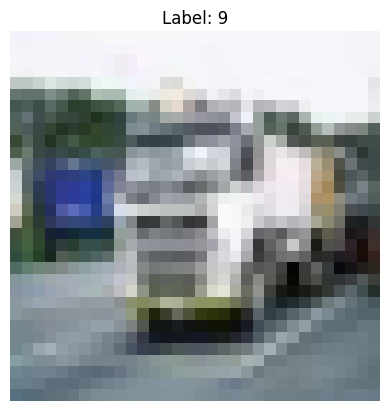

In [26]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
def load_cifar10(path):
    """加载CIFAR-10数据从`path`"""

    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    X_train = []
    y_train = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(path, f'data_batch_{i}'))
        X_train.append(batch[b'data'])
        y_train.append(batch[b'labels'])

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_val = X_train[:1000]
    y_val = y_train[:1000]

    X_train = X_train[1000:]
    y_train = y_train[1000:]

    test_batch = unpickle(os.path.join(path, 'test_batch'))
    X_test = test_batch[b'data']
    y_test = test_batch[b'labels']

    return X_train, y_train, X_val, y_val, X_test, y_test

# show the first image
def show_image(X, y):
    plt.imshow(X.reshape(3, 32, 32).transpose(1, 2, 0))
    plt.title(f'Label: {y}')
    plt.axis('off')
    plt.show()
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10('cifar-10-batches-py')
show_image(X_train[0], y_train[0])

In [27]:
# data preprocessing
# reshape the data (N, 32*32*3)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# normalize the data
X_train = X_train.astype(np.float32) / 255.0
X_val = X_val.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
# convert the labels to one-hot encoding
num_classes = 10
# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)
# print the shape of the data


In [30]:
print(y_train.shape)
print(y_train[0])

(49000,)
9


In [33]:
# y_test = to_categorical(y_test, num_classes)
# print(y_test.shape)#AttributeError: 'list' object has no attribute 'shape'
# list to numpy array
y_test_copy = y_test
y_test_copy = np.array(y_test_copy)
print(y_test_copy.shape)

(10000,)


In [13]:
def grid_search(X_train, y_train, X_val, y_val, input_size, output_size):
    learning_rates = [0.01,0.005]
    hidden_sizes = [128, 256, 512]
    reg_lambdas = [0.01,0.1]
    batch_sizes=[32,64]
    best_val_acc = 0
    best_params = {}
    results = []

# 参数搜索
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for reg_lambda in reg_lambdas:
                for batch_size in batch_sizes:
                    model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
                    print(f"Training with lr={lr}, hidden_size={hidden_size}, reg_lambda={reg_lambda}, batch_size={batch_size}")
                    train(X_train, y_train, X_val, y_val, model, epochs=50, batch_size=batch_size, lr=lr, reg_lambda=reg_lambda)
                    val_acc, _ = evaluate_model(model, X_val, y_val)
                    results.append((lr, hidden_size, reg_lambda, batch_size, val_acc))
                    print(f"Validation accuracy: {val_acc:.4f}")
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_params = {'lr': lr, 'hidden_size': hidden_size, 'reg_lambda': reg_lambda, 'batch_size': batch_size}
                        print(f"New best params found: {best_params}, val_acc: {val_acc:.4f}")

    # 保存或返回结果
    return best_params, best_val_acc, results


Training with lr=0.01, hidden_size=128, reg_lambda=0.01, batch_size=32
Epoch 1, Train Loss: 1.8925
Epoch 1, Validation Accuracy: 0.3750
Epoch 2, Train Loss: 1.7253
Epoch 2, Validation Accuracy: 0.3410
Epoch 3, Train Loss: 1.6679
Epoch 3, Validation Accuracy: 0.3940
Epoch 4, Train Loss: 1.6341
Epoch 4, Validation Accuracy: 0.3820
Epoch 5, Train Loss: 1.6103
Epoch 5, Validation Accuracy: 0.3880
Epoch 6, Train Loss: 1.5908
Epoch 6, Validation Accuracy: 0.4030
Epoch 7, Train Loss: 1.5782
Epoch 7, Validation Accuracy: 0.4360
Epoch 8, Train Loss: 1.5657
Epoch 8, Validation Accuracy: 0.4390
Epoch 9, Train Loss: 1.5571
Epoch 9, Validation Accuracy: 0.4070
Epoch 10, Train Loss: 1.5474
Epoch 10, Validation Accuracy: 0.4170
Epoch 11, Train Loss: 1.5398
Epoch 11, Validation Accuracy: 0.4010
Epoch 12, Train Loss: 1.5332
Epoch 12, Validation Accuracy: 0.4190
Epoch 13, Train Loss: 1.5263
Epoch 13, Validation Accuracy: 0.4170
Epoch 14, Train Loss: 1.5219
Epoch 14, Validation Accuracy: 0.3380
Epoch 15,

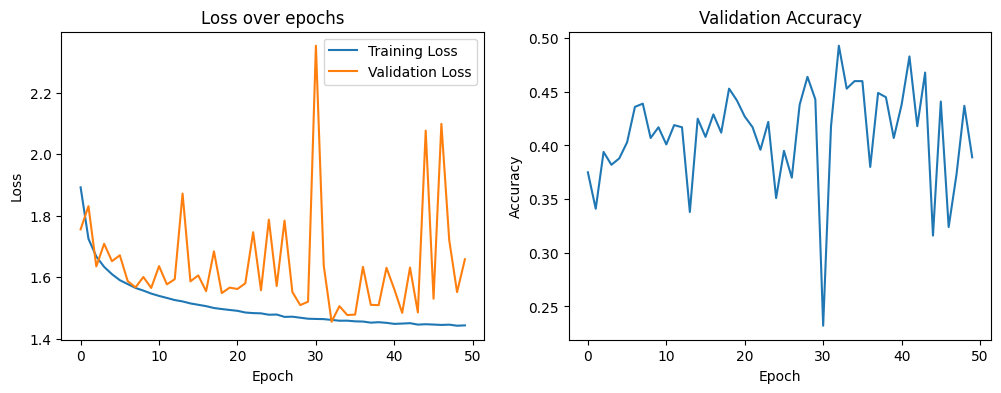

Validation accuracy: 0.3890
New best params found: {'lr': 0.01, 'hidden_size': 128, 'reg_lambda': 0.01, 'batch_size': 32}, val_acc: 0.3890
Training with lr=0.01, hidden_size=128, reg_lambda=0.01, batch_size=64
Epoch 1, Train Loss: 1.9503
Epoch 1, Validation Accuracy: 0.3370
Epoch 2, Train Loss: 1.7797
Epoch 2, Validation Accuracy: 0.3430
Epoch 3, Train Loss: 1.7112
Epoch 3, Validation Accuracy: 0.3820
Epoch 4, Train Loss: 1.6712
Epoch 4, Validation Accuracy: 0.3800
Epoch 5, Train Loss: 1.6400
Epoch 5, Validation Accuracy: 0.3680
Epoch 6, Train Loss: 1.6164
Epoch 6, Validation Accuracy: 0.4130
Epoch 7, Train Loss: 1.6010
Epoch 7, Validation Accuracy: 0.3990
Epoch 8, Train Loss: 1.5866
Epoch 8, Validation Accuracy: 0.4130
Epoch 9, Train Loss: 1.5713
Epoch 9, Validation Accuracy: 0.4230
Epoch 10, Train Loss: 1.5614
Epoch 10, Validation Accuracy: 0.4370
Epoch 11, Train Loss: 1.5501
Epoch 11, Validation Accuracy: 0.4230
Epoch 12, Train Loss: 1.5396
Epoch 12, Validation Accuracy: 0.4490
Epoc

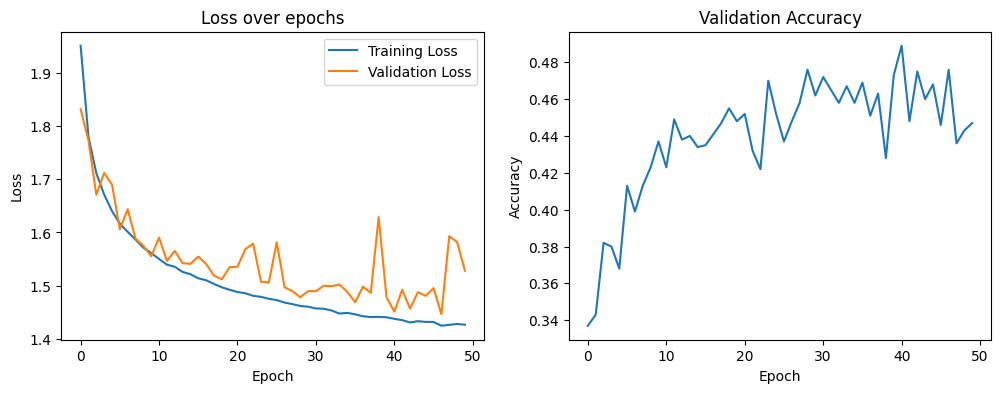

Validation accuracy: 0.4470
New best params found: {'lr': 0.01, 'hidden_size': 128, 'reg_lambda': 0.01, 'batch_size': 64}, val_acc: 0.4470
Training with lr=0.01, hidden_size=128, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 2.0167
Epoch 1, Validation Accuracy: 0.3030
Epoch 2, Train Loss: 2.0198
Epoch 2, Validation Accuracy: 0.2660
Epoch 3, Train Loss: 2.0354
Epoch 3, Validation Accuracy: 0.2480
Epoch 4, Train Loss: 2.0383
Epoch 4, Validation Accuracy: 0.2410
Epoch 5, Train Loss: 2.0389
Epoch 5, Validation Accuracy: 0.2680
Epoch 6, Train Loss: 2.0390
Epoch 6, Validation Accuracy: 0.2530
Epoch 7, Train Loss: 2.0392
Epoch 7, Validation Accuracy: 0.2450
Epoch 8, Train Loss: 2.0405
Epoch 8, Validation Accuracy: 0.2410
Epoch 9, Train Loss: 2.0394
Epoch 9, Validation Accuracy: 0.2570
Epoch 10, Train Loss: 2.0404
Epoch 10, Validation Accuracy: 0.2330
Epoch 11, Train Loss: 2.0394
Epoch 11, Validation Accuracy: 0.2500
Epoch 12, Train Loss: 2.0390
Epoch 12, Validation Accuracy: 0.2610
Epoch

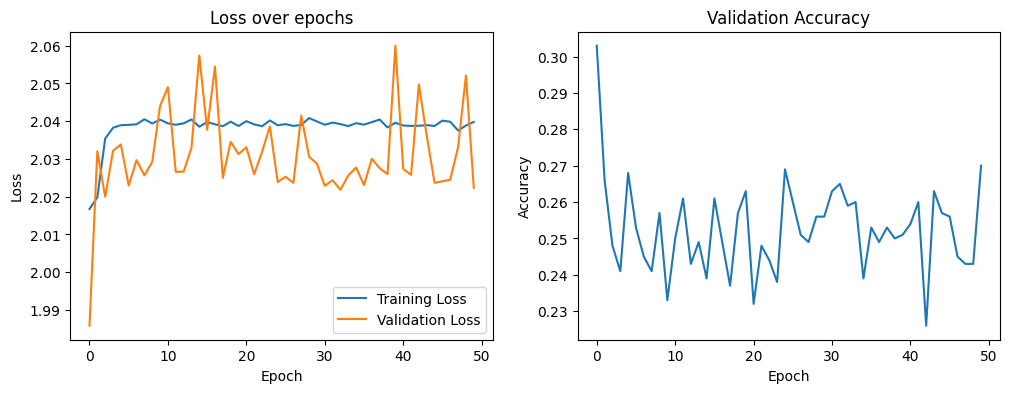

Validation accuracy: 0.2700
Training with lr=0.01, hidden_size=128, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 2.0142
Epoch 1, Validation Accuracy: 0.3240
Epoch 2, Train Loss: 1.9809
Epoch 2, Validation Accuracy: 0.3080
Epoch 3, Train Loss: 2.0062
Epoch 3, Validation Accuracy: 0.2740
Epoch 4, Train Loss: 2.0191
Epoch 4, Validation Accuracy: 0.2750
Epoch 5, Train Loss: 2.0266
Epoch 5, Validation Accuracy: 0.2750
Epoch 6, Train Loss: 2.0296
Epoch 6, Validation Accuracy: 0.2710
Epoch 7, Train Loss: 2.0317
Epoch 7, Validation Accuracy: 0.2740
Epoch 8, Train Loss: 2.0324
Epoch 8, Validation Accuracy: 0.2640
Epoch 9, Train Loss: 2.0340
Epoch 9, Validation Accuracy: 0.2460
Epoch 10, Train Loss: 2.0336
Epoch 10, Validation Accuracy: 0.2490
Epoch 11, Train Loss: 2.0325
Epoch 11, Validation Accuracy: 0.2710
Epoch 12, Train Loss: 2.0335
Epoch 12, Validation Accuracy: 0.2640
Epoch 13, Train Loss: 2.0339
Epoch 13, Validation Accuracy: 0.2550
Epoch 14, Train Loss: 2.0336
Epoch 14, Validation

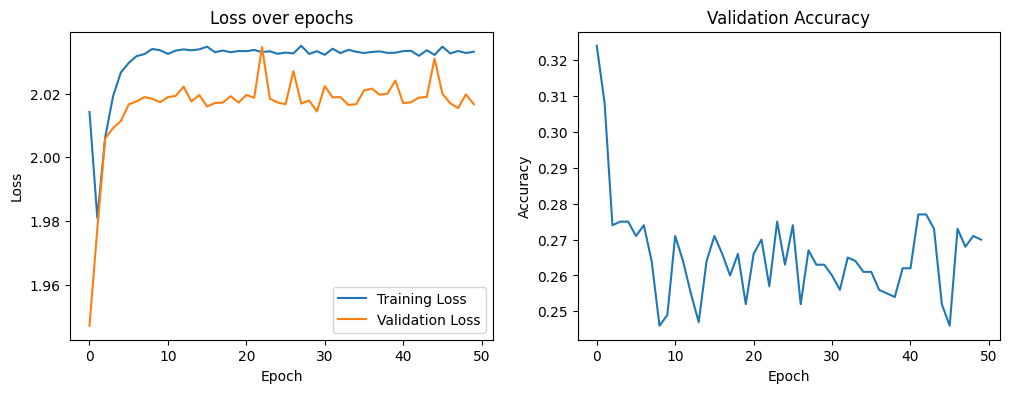

Validation accuracy: 0.2700
Training with lr=0.01, hidden_size=256, reg_lambda=0.01, batch_size=32
Epoch 1, Train Loss: 1.8760
Epoch 1, Validation Accuracy: 0.2950
Epoch 2, Train Loss: 1.7125
Epoch 2, Validation Accuracy: 0.3930
Epoch 3, Train Loss: 1.6507
Epoch 3, Validation Accuracy: 0.3540
Epoch 4, Train Loss: 1.6166
Epoch 4, Validation Accuracy: 0.3990
Epoch 5, Train Loss: 1.5926
Epoch 5, Validation Accuracy: 0.3960
Epoch 6, Train Loss: 1.5734
Epoch 6, Validation Accuracy: 0.3700
Epoch 7, Train Loss: 1.5570
Epoch 7, Validation Accuracy: 0.4210
Epoch 8, Train Loss: 1.5458
Epoch 8, Validation Accuracy: 0.4200
Epoch 9, Train Loss: 1.5335
Epoch 9, Validation Accuracy: 0.4400
Epoch 10, Train Loss: 1.5241
Epoch 10, Validation Accuracy: 0.4330
Epoch 11, Train Loss: 1.5177
Epoch 11, Validation Accuracy: 0.4270
Epoch 12, Train Loss: 1.5106
Epoch 12, Validation Accuracy: 0.4020
Epoch 13, Train Loss: 1.5037
Epoch 13, Validation Accuracy: 0.4110
Epoch 14, Train Loss: 1.4941
Epoch 14, Validatio

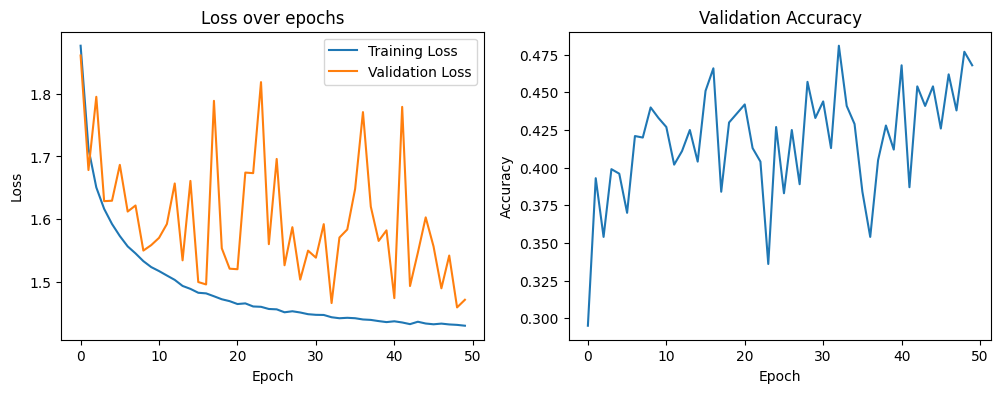

Validation accuracy: 0.4680
New best params found: {'lr': 0.01, 'hidden_size': 256, 'reg_lambda': 0.01, 'batch_size': 32}, val_acc: 0.4680
Training with lr=0.01, hidden_size=256, reg_lambda=0.01, batch_size=64
Epoch 1, Train Loss: 1.9128
Epoch 1, Validation Accuracy: 0.3750
Epoch 2, Train Loss: 1.7526
Epoch 2, Validation Accuracy: 0.3760
Epoch 3, Train Loss: 1.6874
Epoch 3, Validation Accuracy: 0.3800
Epoch 4, Train Loss: 1.6506
Epoch 4, Validation Accuracy: 0.4050
Epoch 5, Train Loss: 1.6230
Epoch 5, Validation Accuracy: 0.3970
Epoch 6, Train Loss: 1.6025
Epoch 6, Validation Accuracy: 0.4200
Epoch 7, Train Loss: 1.5856
Epoch 7, Validation Accuracy: 0.4020
Epoch 8, Train Loss: 1.5712
Epoch 8, Validation Accuracy: 0.4130
Epoch 9, Train Loss: 1.5611
Epoch 9, Validation Accuracy: 0.4070
Epoch 10, Train Loss: 1.5489
Epoch 10, Validation Accuracy: 0.4180
Epoch 11, Train Loss: 1.5404
Epoch 11, Validation Accuracy: 0.4500
Epoch 12, Train Loss: 1.5309
Epoch 12, Validation Accuracy: 0.4370
Epoc

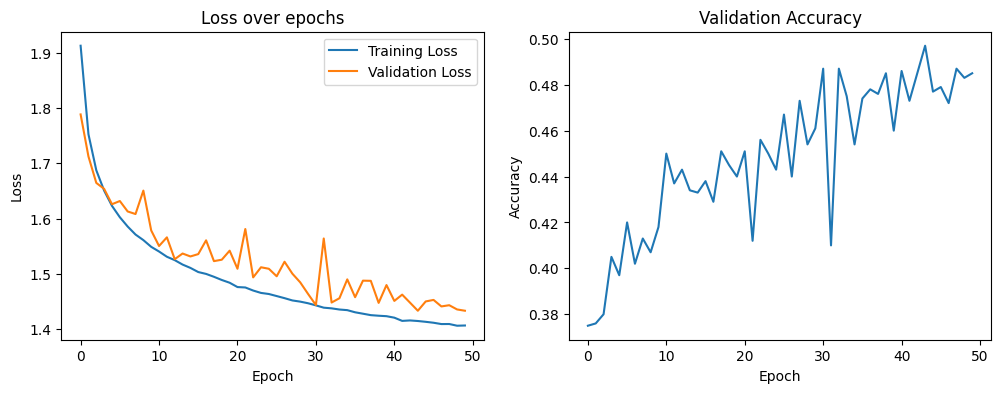

Validation accuracy: 0.4850
New best params found: {'lr': 0.01, 'hidden_size': 256, 'reg_lambda': 0.01, 'batch_size': 64}, val_acc: 0.4850
Training with lr=0.01, hidden_size=256, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 2.0048
Epoch 1, Validation Accuracy: 0.2920
Epoch 2, Train Loss: 2.0191
Epoch 2, Validation Accuracy: 0.2600
Epoch 3, Train Loss: 2.0336
Epoch 3, Validation Accuracy: 0.2420
Epoch 4, Train Loss: 2.0379
Epoch 4, Validation Accuracy: 0.2370
Epoch 5, Train Loss: 2.0382
Epoch 5, Validation Accuracy: 0.2620
Epoch 6, Train Loss: 2.0389
Epoch 6, Validation Accuracy: 0.2560
Epoch 7, Train Loss: 2.0405
Epoch 7, Validation Accuracy: 0.2540
Epoch 8, Train Loss: 2.0391
Epoch 8, Validation Accuracy: 0.2660
Epoch 9, Train Loss: 2.0408
Epoch 9, Validation Accuracy: 0.2400
Epoch 10, Train Loss: 2.0388
Epoch 10, Validation Accuracy: 0.2440
Epoch 11, Train Loss: 2.0393
Epoch 11, Validation Accuracy: 0.2570
Epoch 12, Train Loss: 2.0401
Epoch 12, Validation Accuracy: 0.2440
Epoch

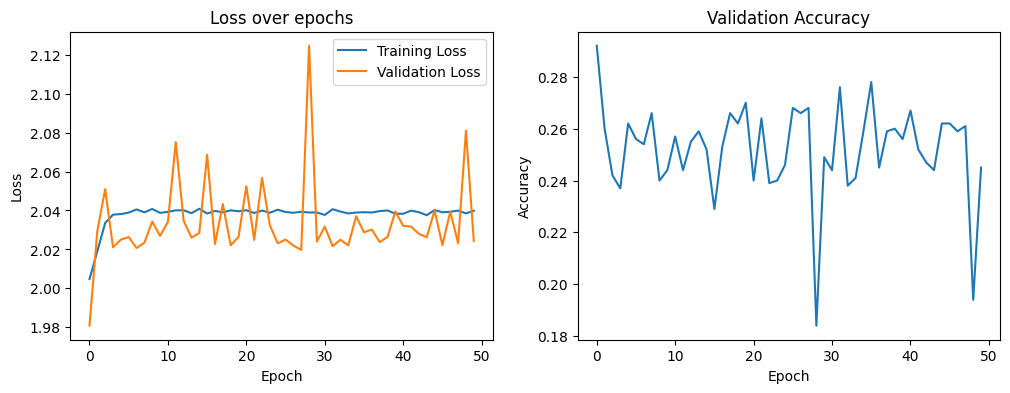

Validation accuracy: 0.2450
Training with lr=0.01, hidden_size=256, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 1.9871
Epoch 1, Validation Accuracy: 0.3460
Epoch 2, Train Loss: 1.9713
Epoch 2, Validation Accuracy: 0.3060
Epoch 3, Train Loss: 2.0002
Epoch 3, Validation Accuracy: 0.2900
Epoch 4, Train Loss: 2.0159
Epoch 4, Validation Accuracy: 0.2980
Epoch 5, Train Loss: 2.0234
Epoch 5, Validation Accuracy: 0.2780
Epoch 6, Train Loss: 2.0297
Epoch 6, Validation Accuracy: 0.2720
Epoch 7, Train Loss: 2.0314
Epoch 7, Validation Accuracy: 0.2760
Epoch 8, Train Loss: 2.0326
Epoch 8, Validation Accuracy: 0.2690
Epoch 9, Train Loss: 2.0333
Epoch 9, Validation Accuracy: 0.2660
Epoch 10, Train Loss: 2.0336
Epoch 10, Validation Accuracy: 0.2630
Epoch 11, Train Loss: 2.0343
Epoch 11, Validation Accuracy: 0.2570
Epoch 12, Train Loss: 2.0341
Epoch 12, Validation Accuracy: 0.2490
Epoch 13, Train Loss: 2.0335
Epoch 13, Validation Accuracy: 0.2710
Epoch 14, Train Loss: 2.0332
Epoch 14, Validation

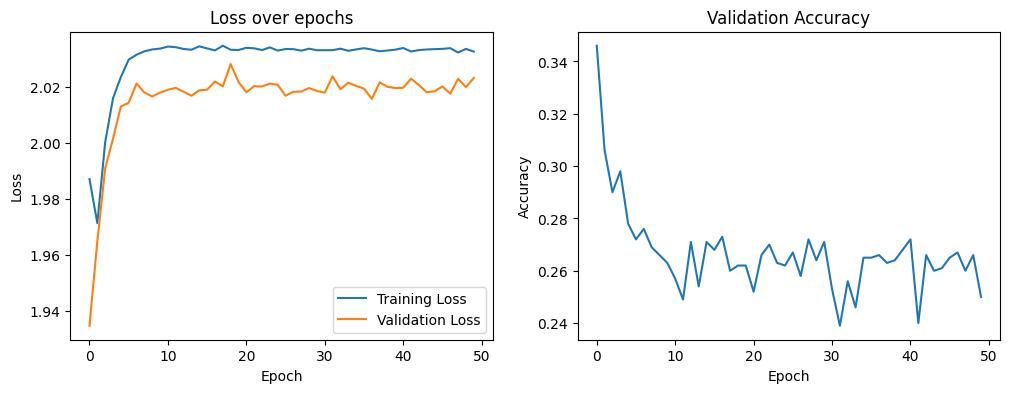

Validation accuracy: 0.2500
Training with lr=0.01, hidden_size=512, reg_lambda=0.01, batch_size=32
Epoch 1, Train Loss: 1.8490
Epoch 1, Validation Accuracy: 0.3710
Epoch 2, Train Loss: 1.6867
Epoch 2, Validation Accuracy: 0.3190
Epoch 3, Train Loss: 1.6295
Epoch 3, Validation Accuracy: 0.3060
Epoch 4, Train Loss: 1.5947
Epoch 4, Validation Accuracy: 0.3820
Epoch 5, Train Loss: 1.5725
Epoch 5, Validation Accuracy: 0.3940
Epoch 6, Train Loss: 1.5571
Epoch 6, Validation Accuracy: 0.4240
Epoch 7, Train Loss: 1.5433
Epoch 7, Validation Accuracy: 0.4300
Epoch 8, Train Loss: 1.5302
Epoch 8, Validation Accuracy: 0.3890
Epoch 9, Train Loss: 1.5217
Epoch 9, Validation Accuracy: 0.4190
Epoch 10, Train Loss: 1.5122
Epoch 10, Validation Accuracy: 0.4380
Epoch 11, Train Loss: 1.5063
Epoch 11, Validation Accuracy: 0.4410
Epoch 12, Train Loss: 1.4985
Epoch 12, Validation Accuracy: 0.4150
Epoch 13, Train Loss: 1.4911
Epoch 13, Validation Accuracy: 0.4040
Epoch 14, Train Loss: 1.4868
Epoch 14, Validatio

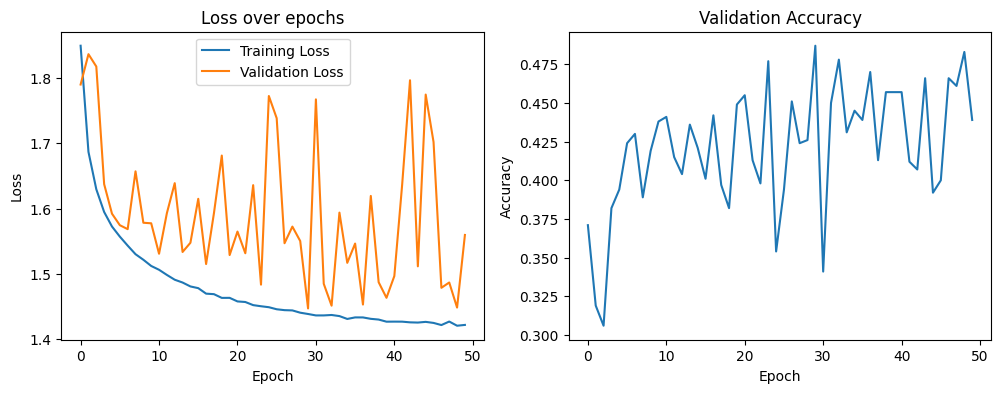

Validation accuracy: 0.4390
Training with lr=0.01, hidden_size=512, reg_lambda=0.01, batch_size=64
Epoch 1, Train Loss: 1.8911
Epoch 1, Validation Accuracy: 0.3350
Epoch 2, Train Loss: 1.7325
Epoch 2, Validation Accuracy: 0.4010
Epoch 3, Train Loss: 1.6705
Epoch 3, Validation Accuracy: 0.4150
Epoch 4, Train Loss: 1.6317
Epoch 4, Validation Accuracy: 0.4020
Epoch 5, Train Loss: 1.6049
Epoch 5, Validation Accuracy: 0.4080
Epoch 6, Train Loss: 1.5839
Epoch 6, Validation Accuracy: 0.4260
Epoch 7, Train Loss: 1.5661
Epoch 7, Validation Accuracy: 0.4220
Epoch 8, Train Loss: 1.5518
Epoch 8, Validation Accuracy: 0.4360
Epoch 9, Train Loss: 1.5391
Epoch 9, Validation Accuracy: 0.4300
Epoch 10, Train Loss: 1.5276
Epoch 10, Validation Accuracy: 0.4570
Epoch 11, Train Loss: 1.5195
Epoch 11, Validation Accuracy: 0.4020
Epoch 12, Train Loss: 1.5103
Epoch 12, Validation Accuracy: 0.4540
Epoch 13, Train Loss: 1.4996
Epoch 13, Validation Accuracy: 0.4470
Epoch 14, Train Loss: 1.4932
Epoch 14, Validatio

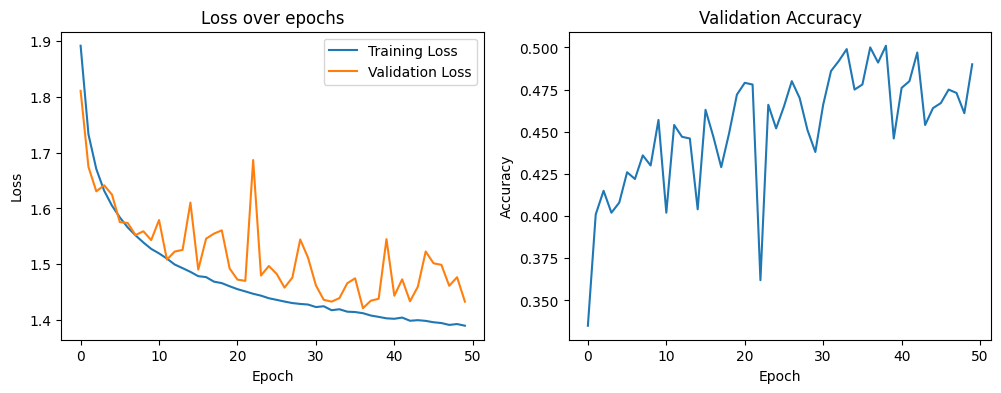

Validation accuracy: 0.4900
New best params found: {'lr': 0.01, 'hidden_size': 512, 'reg_lambda': 0.01, 'batch_size': 64}, val_acc: 0.4900
Training with lr=0.01, hidden_size=512, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 1.9836
Epoch 1, Validation Accuracy: 0.3070
Epoch 2, Train Loss: 2.0147
Epoch 2, Validation Accuracy: 0.2640
Epoch 3, Train Loss: 2.0327
Epoch 3, Validation Accuracy: 0.2460
Epoch 4, Train Loss: 2.0385
Epoch 4, Validation Accuracy: 0.2590
Epoch 5, Train Loss: 2.0383
Epoch 5, Validation Accuracy: 0.2400
Epoch 6, Train Loss: 2.0391
Epoch 6, Validation Accuracy: 0.2510
Epoch 7, Train Loss: 2.0402
Epoch 7, Validation Accuracy: 0.2610
Epoch 8, Train Loss: 2.0395
Epoch 8, Validation Accuracy: 0.2480
Epoch 9, Train Loss: 2.0394
Epoch 9, Validation Accuracy: 0.2740
Epoch 10, Train Loss: 2.0399
Epoch 10, Validation Accuracy: 0.2480
Epoch 11, Train Loss: 2.0401
Epoch 11, Validation Accuracy: 0.2580
Epoch 12, Train Loss: 2.0395
Epoch 12, Validation Accuracy: 0.2490
Epoch

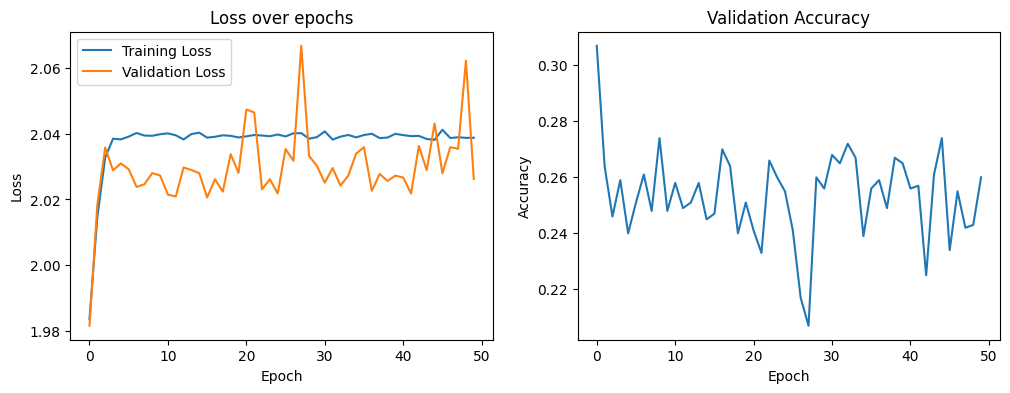

Validation accuracy: 0.2600
Training with lr=0.01, hidden_size=512, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 1.9731
Epoch 1, Validation Accuracy: 0.3430
Epoch 2, Train Loss: 1.9629
Epoch 2, Validation Accuracy: 0.3060
Epoch 3, Train Loss: 1.9978
Epoch 3, Validation Accuracy: 0.3020
Epoch 4, Train Loss: 2.0137
Epoch 4, Validation Accuracy: 0.2950
Epoch 5, Train Loss: 2.0231
Epoch 5, Validation Accuracy: 0.2800
Epoch 6, Train Loss: 2.0272
Epoch 6, Validation Accuracy: 0.2720
Epoch 7, Train Loss: 2.0315
Epoch 7, Validation Accuracy: 0.2460
Epoch 8, Train Loss: 2.0325
Epoch 8, Validation Accuracy: 0.2470
Epoch 9, Train Loss: 2.0334
Epoch 9, Validation Accuracy: 0.2450
Epoch 10, Train Loss: 2.0338
Epoch 10, Validation Accuracy: 0.2710
Epoch 11, Train Loss: 2.0332
Epoch 11, Validation Accuracy: 0.2600
Epoch 12, Train Loss: 2.0329
Epoch 12, Validation Accuracy: 0.2500
Epoch 13, Train Loss: 2.0343
Epoch 13, Validation Accuracy: 0.2690
Epoch 14, Train Loss: 2.0337
Epoch 14, Validation

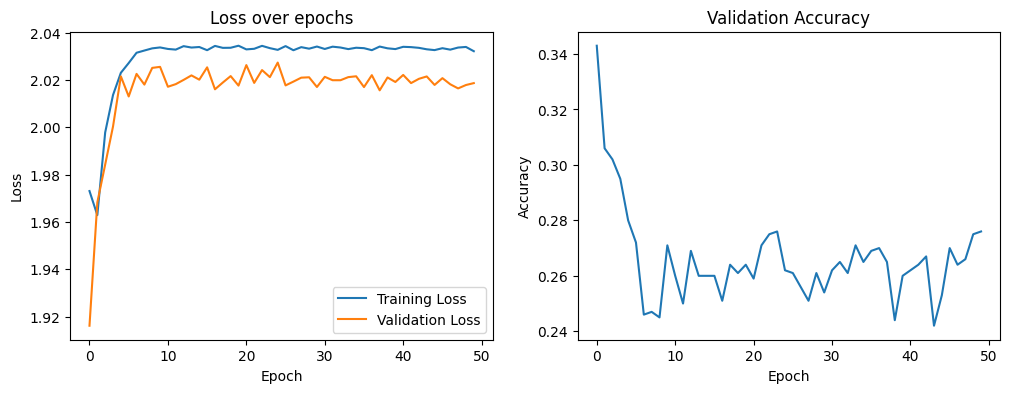

Validation accuracy: 0.2760
Training with lr=0.005, hidden_size=128, reg_lambda=0.01, batch_size=32
Epoch 1, Train Loss: 1.9321
Epoch 1, Validation Accuracy: 0.3430
Epoch 2, Train Loss: 1.7626
Epoch 2, Validation Accuracy: 0.3720
Epoch 3, Train Loss: 1.7016
Epoch 3, Validation Accuracy: 0.3810
Epoch 4, Train Loss: 1.6629
Epoch 4, Validation Accuracy: 0.3740
Epoch 5, Train Loss: 1.6365
Epoch 5, Validation Accuracy: 0.4000
Epoch 6, Train Loss: 1.6136
Epoch 6, Validation Accuracy: 0.3890
Epoch 7, Train Loss: 1.5962
Epoch 7, Validation Accuracy: 0.4050
Epoch 8, Train Loss: 1.5806
Epoch 8, Validation Accuracy: 0.4120
Epoch 9, Train Loss: 1.5681
Epoch 9, Validation Accuracy: 0.4300
Epoch 10, Train Loss: 1.5556
Epoch 10, Validation Accuracy: 0.4110
Epoch 11, Train Loss: 1.5463
Epoch 11, Validation Accuracy: 0.4300
Epoch 12, Train Loss: 1.5348
Epoch 12, Validation Accuracy: 0.4070
Epoch 13, Train Loss: 1.5278
Epoch 13, Validation Accuracy: 0.4350
Epoch 14, Train Loss: 1.5201
Epoch 14, Validati

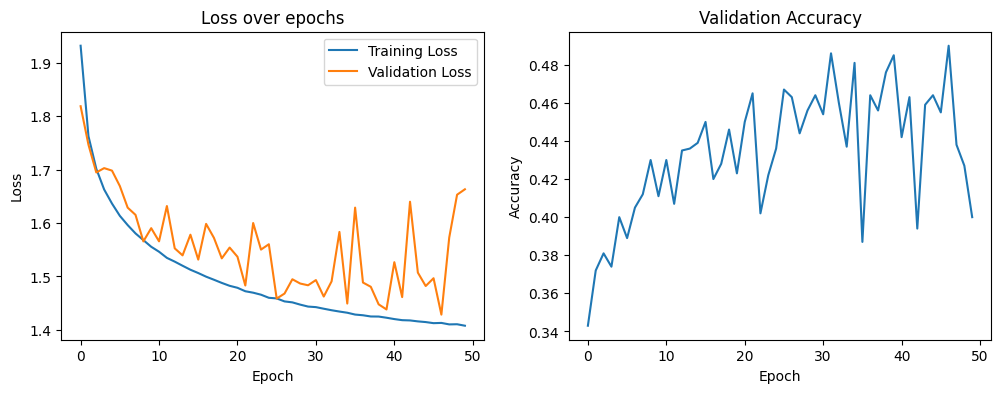

Validation accuracy: 0.4000
Training with lr=0.005, hidden_size=128, reg_lambda=0.01, batch_size=64
Epoch 1, Train Loss: 1.9931
Epoch 1, Validation Accuracy: 0.3470
Epoch 2, Train Loss: 1.8213
Epoch 2, Validation Accuracy: 0.3680
Epoch 3, Train Loss: 1.7584
Epoch 3, Validation Accuracy: 0.3720
Epoch 4, Train Loss: 1.7168
Epoch 4, Validation Accuracy: 0.3820
Epoch 5, Train Loss: 1.6867
Epoch 5, Validation Accuracy: 0.4080
Epoch 6, Train Loss: 1.6640
Epoch 6, Validation Accuracy: 0.4030
Epoch 7, Train Loss: 1.6437
Epoch 7, Validation Accuracy: 0.3900
Epoch 8, Train Loss: 1.6271
Epoch 8, Validation Accuracy: 0.4050
Epoch 9, Train Loss: 1.6137
Epoch 9, Validation Accuracy: 0.4260
Epoch 10, Train Loss: 1.6011
Epoch 10, Validation Accuracy: 0.4140
Epoch 11, Train Loss: 1.5902
Epoch 11, Validation Accuracy: 0.4320
Epoch 12, Train Loss: 1.5815
Epoch 12, Validation Accuracy: 0.4220
Epoch 13, Train Loss: 1.5730
Epoch 13, Validation Accuracy: 0.4340
Epoch 14, Train Loss: 1.5635
Epoch 14, Validati

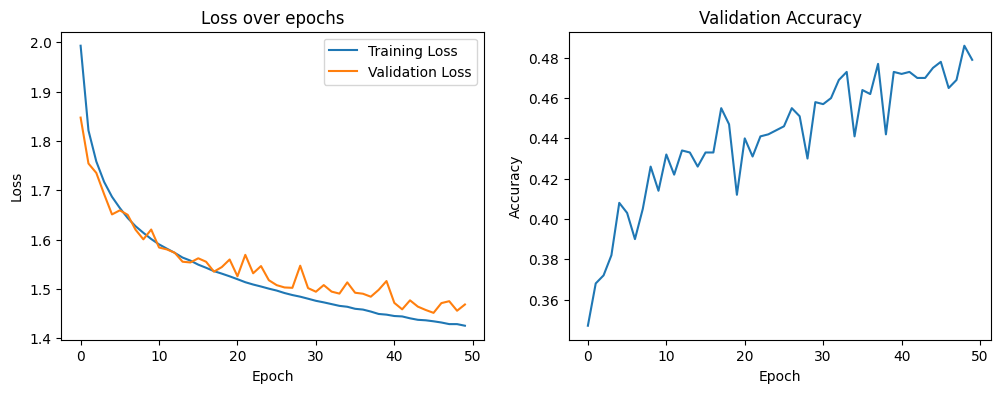

Validation accuracy: 0.4790
Training with lr=0.005, hidden_size=128, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 2.0032
Epoch 1, Validation Accuracy: 0.3070
Epoch 2, Train Loss: 1.9791
Epoch 2, Validation Accuracy: 0.3140
Epoch 3, Train Loss: 2.0041
Epoch 3, Validation Accuracy: 0.2710
Epoch 4, Train Loss: 2.0171
Epoch 4, Validation Accuracy: 0.2860
Epoch 5, Train Loss: 2.0248
Epoch 5, Validation Accuracy: 0.2700
Epoch 6, Train Loss: 2.0296
Epoch 6, Validation Accuracy: 0.2720
Epoch 7, Train Loss: 2.0315
Epoch 7, Validation Accuracy: 0.2600
Epoch 8, Train Loss: 2.0327
Epoch 8, Validation Accuracy: 0.2470
Epoch 9, Train Loss: 2.0329
Epoch 9, Validation Accuracy: 0.2560
Epoch 10, Train Loss: 2.0327
Epoch 10, Validation Accuracy: 0.2680
Epoch 11, Train Loss: 2.0338
Epoch 11, Validation Accuracy: 0.2700
Epoch 12, Train Loss: 2.0326
Epoch 12, Validation Accuracy: 0.2740
Epoch 13, Train Loss: 2.0329
Epoch 13, Validation Accuracy: 0.2610
Epoch 14, Train Loss: 2.0332
Epoch 14, Validatio

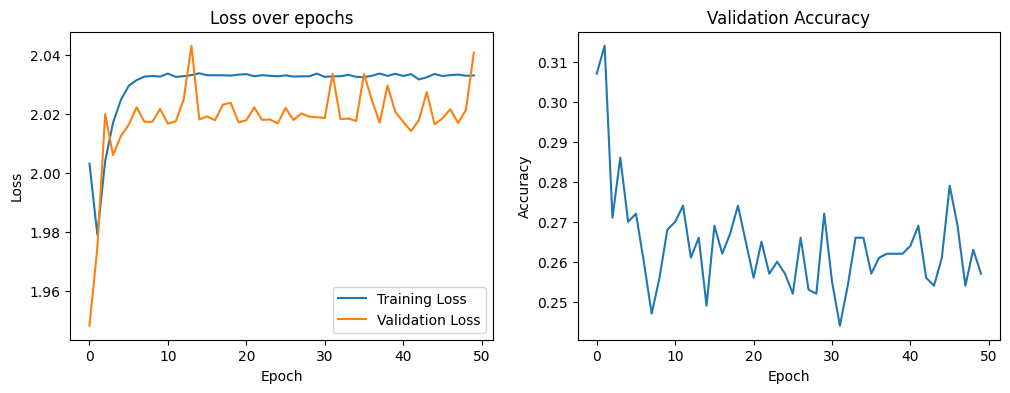

Validation accuracy: 0.2570
Training with lr=0.005, hidden_size=128, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 2.0299
Epoch 1, Validation Accuracy: 0.3180
Epoch 2, Train Loss: 1.9513
Epoch 2, Validation Accuracy: 0.3330
Epoch 3, Train Loss: 1.9622
Epoch 3, Validation Accuracy: 0.3390
Epoch 4, Train Loss: 1.9800
Epoch 4, Validation Accuracy: 0.3050
Epoch 5, Train Loss: 1.9935
Epoch 5, Validation Accuracy: 0.3220
Epoch 6, Train Loss: 2.0038
Epoch 6, Validation Accuracy: 0.2940
Epoch 7, Train Loss: 2.0109
Epoch 7, Validation Accuracy: 0.3040
Epoch 8, Train Loss: 2.0155
Epoch 8, Validation Accuracy: 0.2890
Epoch 9, Train Loss: 2.0201
Epoch 9, Validation Accuracy: 0.2910
Epoch 10, Train Loss: 2.0225
Epoch 10, Validation Accuracy: 0.2810
Epoch 11, Train Loss: 2.0257
Epoch 11, Validation Accuracy: 0.2770
Epoch 12, Train Loss: 2.0267
Epoch 12, Validation Accuracy: 0.2680
Epoch 13, Train Loss: 2.0278
Epoch 13, Validation Accuracy: 0.2710
Epoch 14, Train Loss: 2.0281
Epoch 14, Validatio

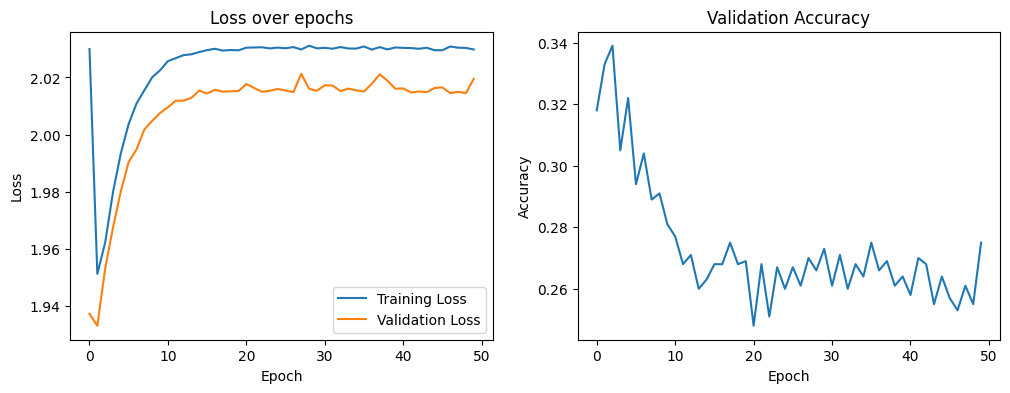

Validation accuracy: 0.2750
Training with lr=0.005, hidden_size=256, reg_lambda=0.01, batch_size=32
Epoch 1, Train Loss: 1.8961
Epoch 1, Validation Accuracy: 0.3300
Epoch 2, Train Loss: 1.7398
Epoch 2, Validation Accuracy: 0.3690
Epoch 3, Train Loss: 1.6789
Epoch 3, Validation Accuracy: 0.3510
Epoch 4, Train Loss: 1.6386
Epoch 4, Validation Accuracy: 0.3340
Epoch 5, Train Loss: 1.6117
Epoch 5, Validation Accuracy: 0.3870
Epoch 6, Train Loss: 1.5924
Epoch 6, Validation Accuracy: 0.4070
Epoch 7, Train Loss: 1.5749
Epoch 7, Validation Accuracy: 0.4160
Epoch 8, Train Loss: 1.5603
Epoch 8, Validation Accuracy: 0.4290
Epoch 9, Train Loss: 1.5472
Epoch 9, Validation Accuracy: 0.3960
Epoch 10, Train Loss: 1.5369
Epoch 10, Validation Accuracy: 0.4350
Epoch 11, Train Loss: 1.5268
Epoch 11, Validation Accuracy: 0.4420
Epoch 12, Train Loss: 1.5172
Epoch 12, Validation Accuracy: 0.4490
Epoch 13, Train Loss: 1.5083
Epoch 13, Validation Accuracy: 0.4360
Epoch 14, Train Loss: 1.5013
Epoch 14, Validati

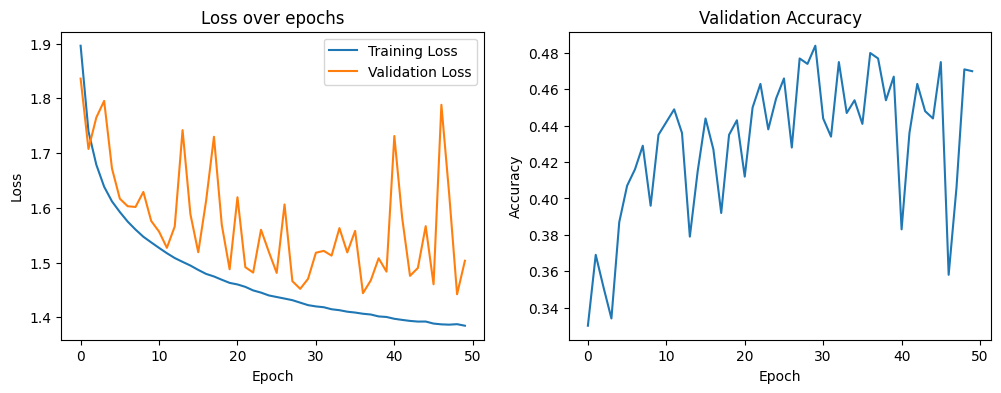

Validation accuracy: 0.4700
Training with lr=0.005, hidden_size=256, reg_lambda=0.01, batch_size=64
Epoch 1, Train Loss: 1.9598
Epoch 1, Validation Accuracy: 0.3600
Epoch 2, Train Loss: 1.7946
Epoch 2, Validation Accuracy: 0.3630
Epoch 3, Train Loss: 1.7312
Epoch 3, Validation Accuracy: 0.3870
Epoch 4, Train Loss: 1.6908
Epoch 4, Validation Accuracy: 0.4190
Epoch 5, Train Loss: 1.6621
Epoch 5, Validation Accuracy: 0.3870
Epoch 6, Train Loss: 1.6400
Epoch 6, Validation Accuracy: 0.4180
Epoch 7, Train Loss: 1.6209
Epoch 7, Validation Accuracy: 0.4140
Epoch 8, Train Loss: 1.6052
Epoch 8, Validation Accuracy: 0.4180
Epoch 9, Train Loss: 1.5922
Epoch 9, Validation Accuracy: 0.4320
Epoch 10, Train Loss: 1.5789
Epoch 10, Validation Accuracy: 0.4270
Epoch 11, Train Loss: 1.5684
Epoch 11, Validation Accuracy: 0.4310
Epoch 12, Train Loss: 1.5605
Epoch 12, Validation Accuracy: 0.4310
Epoch 13, Train Loss: 1.5508
Epoch 13, Validation Accuracy: 0.4400
Epoch 14, Train Loss: 1.5433
Epoch 14, Validati

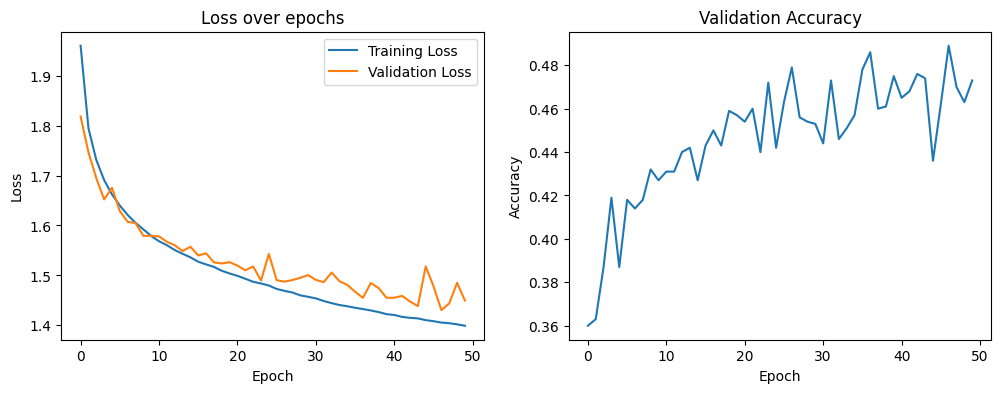

Validation accuracy: 0.4730
Training with lr=0.005, hidden_size=256, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 1.9853
Epoch 1, Validation Accuracy: 0.3210
Epoch 2, Train Loss: 1.9684
Epoch 2, Validation Accuracy: 0.3120
Epoch 3, Train Loss: 1.9991
Epoch 3, Validation Accuracy: 0.2950
Epoch 4, Train Loss: 2.0148
Epoch 4, Validation Accuracy: 0.2870
Epoch 5, Train Loss: 2.0223
Epoch 5, Validation Accuracy: 0.2550
Epoch 6, Train Loss: 2.0280
Epoch 6, Validation Accuracy: 0.2810
Epoch 7, Train Loss: 2.0306
Epoch 7, Validation Accuracy: 0.2500
Epoch 8, Train Loss: 2.0321
Epoch 8, Validation Accuracy: 0.2720
Epoch 9, Train Loss: 2.0327
Epoch 9, Validation Accuracy: 0.2700
Epoch 10, Train Loss: 2.0324
Epoch 10, Validation Accuracy: 0.2630
Epoch 11, Train Loss: 2.0330
Epoch 11, Validation Accuracy: 0.2430
Epoch 12, Train Loss: 2.0329
Epoch 12, Validation Accuracy: 0.2760
Epoch 13, Train Loss: 2.0333
Epoch 13, Validation Accuracy: 0.2700
Epoch 14, Train Loss: 2.0333
Epoch 14, Validatio

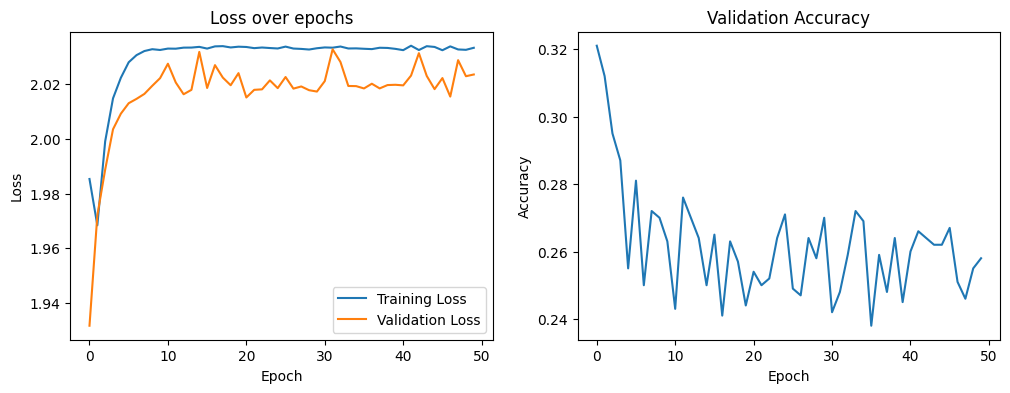

Validation accuracy: 0.2580
Training with lr=0.005, hidden_size=256, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 2.0050
Epoch 1, Validation Accuracy: 0.3190
Epoch 2, Train Loss: 1.9337
Epoch 2, Validation Accuracy: 0.3470
Epoch 3, Train Loss: 1.9503
Epoch 3, Validation Accuracy: 0.3440
Epoch 4, Train Loss: 1.9720
Epoch 4, Validation Accuracy: 0.3310
Epoch 5, Train Loss: 1.9871
Epoch 5, Validation Accuracy: 0.3010
Epoch 6, Train Loss: 1.9984
Epoch 6, Validation Accuracy: 0.3030
Epoch 7, Train Loss: 2.0073
Epoch 7, Validation Accuracy: 0.2950
Epoch 8, Train Loss: 2.0137
Epoch 8, Validation Accuracy: 0.2840
Epoch 9, Train Loss: 2.0176
Epoch 9, Validation Accuracy: 0.2700
Epoch 10, Train Loss: 2.0207
Epoch 10, Validation Accuracy: 0.2860
Epoch 11, Train Loss: 2.0232
Epoch 11, Validation Accuracy: 0.2910
Epoch 12, Train Loss: 2.0251
Epoch 12, Validation Accuracy: 0.2790
Epoch 13, Train Loss: 2.0275
Epoch 13, Validation Accuracy: 0.2730
Epoch 14, Train Loss: 2.0277
Epoch 14, Validatio

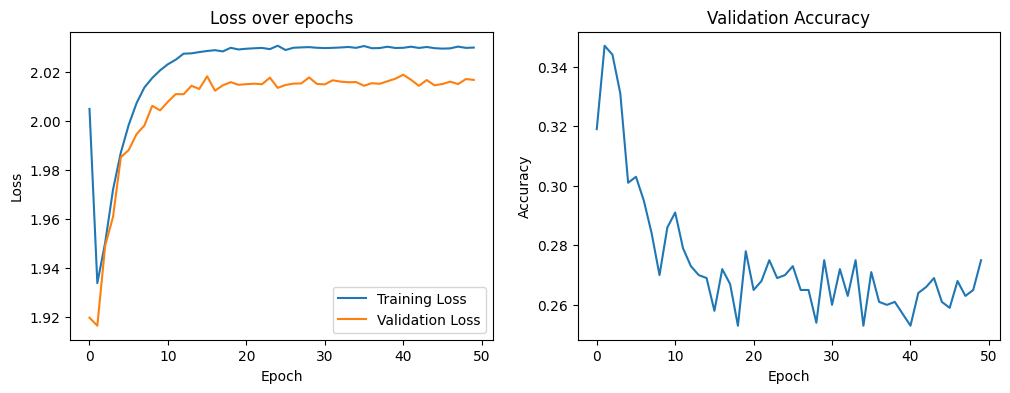

Validation accuracy: 0.2750
Training with lr=0.005, hidden_size=512, reg_lambda=0.01, batch_size=32
Epoch 1, Train Loss: 1.8895
Epoch 1, Validation Accuracy: 0.3050
Epoch 2, Train Loss: 1.7277
Epoch 2, Validation Accuracy: 0.3910
Epoch 3, Train Loss: 1.6661
Epoch 3, Validation Accuracy: 0.3970
Epoch 4, Train Loss: 1.6262
Epoch 4, Validation Accuracy: 0.3950
Epoch 5, Train Loss: 1.5978
Epoch 5, Validation Accuracy: 0.3990
Epoch 6, Train Loss: 1.5751
Epoch 6, Validation Accuracy: 0.4090
Epoch 7, Train Loss: 1.5579
Epoch 7, Validation Accuracy: 0.4330
Epoch 8, Train Loss: 1.5419
Epoch 8, Validation Accuracy: 0.4250
Epoch 9, Train Loss: 1.5287
Epoch 9, Validation Accuracy: 0.4190
Epoch 10, Train Loss: 1.5165
Epoch 10, Validation Accuracy: 0.4190
Epoch 11, Train Loss: 1.5061
Epoch 11, Validation Accuracy: 0.4450
Epoch 12, Train Loss: 1.4959
Epoch 12, Validation Accuracy: 0.4380
Epoch 13, Train Loss: 1.4899
Epoch 13, Validation Accuracy: 0.4170
Epoch 14, Train Loss: 1.4796
Epoch 14, Validati

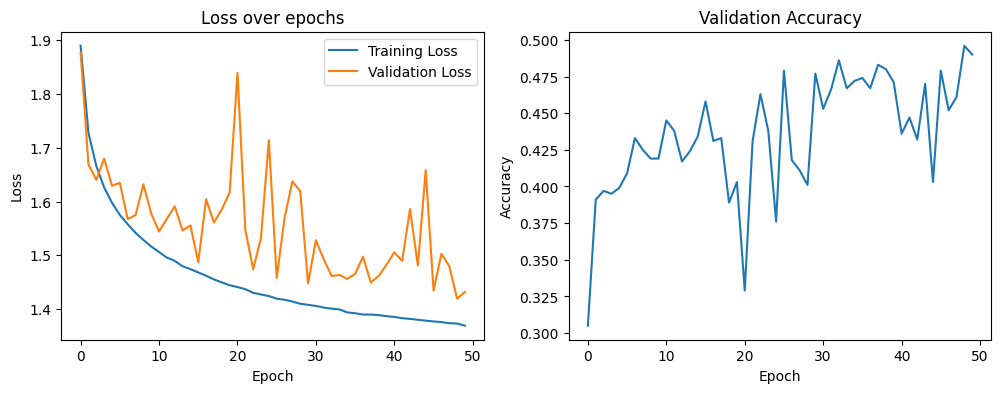

Validation accuracy: 0.4900
Training with lr=0.005, hidden_size=512, reg_lambda=0.01, batch_size=64
Epoch 1, Train Loss: 1.9276
Epoch 1, Validation Accuracy: 0.3590
Epoch 2, Train Loss: 1.7752
Epoch 2, Validation Accuracy: 0.3980
Epoch 3, Train Loss: 1.7176
Epoch 3, Validation Accuracy: 0.3940
Epoch 4, Train Loss: 1.6765
Epoch 4, Validation Accuracy: 0.4150
Epoch 5, Train Loss: 1.6453
Epoch 5, Validation Accuracy: 0.4250
Epoch 6, Train Loss: 1.6216
Epoch 6, Validation Accuracy: 0.4140
Epoch 7, Train Loss: 1.6020
Epoch 7, Validation Accuracy: 0.4240
Epoch 8, Train Loss: 1.5856
Epoch 8, Validation Accuracy: 0.4100
Epoch 9, Train Loss: 1.5723
Epoch 9, Validation Accuracy: 0.4360
Epoch 10, Train Loss: 1.5595
Epoch 10, Validation Accuracy: 0.4230
Epoch 11, Train Loss: 1.5477
Epoch 11, Validation Accuracy: 0.4330
Epoch 12, Train Loss: 1.5378
Epoch 12, Validation Accuracy: 0.4320
Epoch 13, Train Loss: 1.5277
Epoch 13, Validation Accuracy: 0.4310
Epoch 14, Train Loss: 1.5210
Epoch 14, Validati

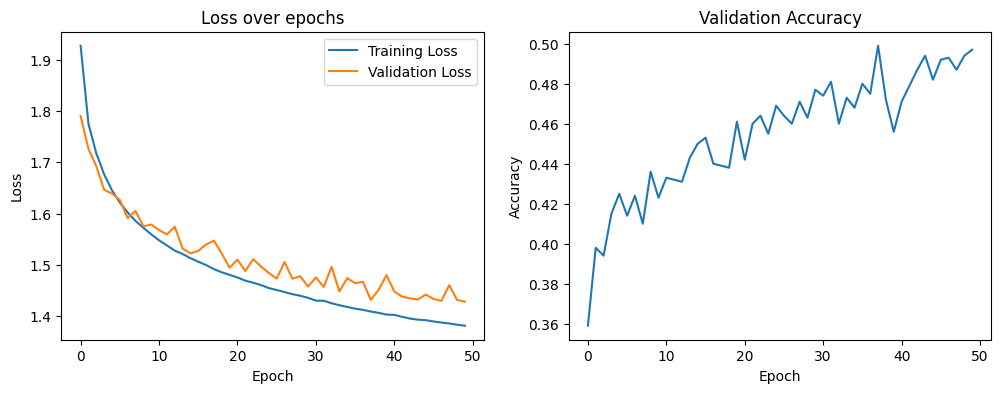

Validation accuracy: 0.4970
New best params found: {'lr': 0.005, 'hidden_size': 512, 'reg_lambda': 0.01, 'batch_size': 64}, val_acc: 0.4970
Training with lr=0.005, hidden_size=512, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 1.9583
Epoch 1, Validation Accuracy: 0.3230
Epoch 2, Train Loss: 1.9579
Epoch 2, Validation Accuracy: 0.3180
Epoch 3, Train Loss: 1.9938
Epoch 3, Validation Accuracy: 0.2910
Epoch 4, Train Loss: 2.0121
Epoch 4, Validation Accuracy: 0.2670
Epoch 5, Train Loss: 2.0214
Epoch 5, Validation Accuracy: 0.2630
Epoch 6, Train Loss: 2.0275
Epoch 6, Validation Accuracy: 0.2550
Epoch 7, Train Loss: 2.0305
Epoch 7, Validation Accuracy: 0.2750
Epoch 8, Train Loss: 2.0308
Epoch 8, Validation Accuracy: 0.2630
Epoch 9, Train Loss: 2.0317
Epoch 9, Validation Accuracy: 0.2830
Epoch 10, Train Loss: 2.0323
Epoch 10, Validation Accuracy: 0.2650
Epoch 11, Train Loss: 2.0331
Epoch 11, Validation Accuracy: 0.2690
Epoch 12, Train Loss: 2.0325
Epoch 12, Validation Accuracy: 0.2730
Epo

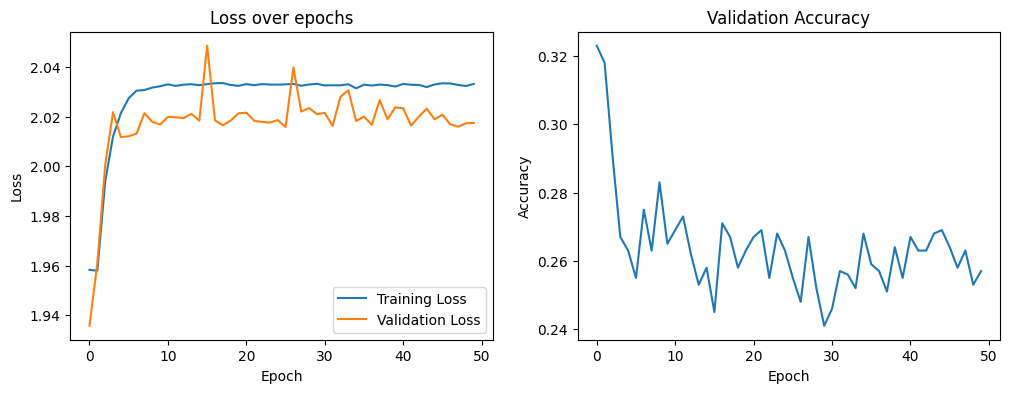

Validation accuracy: 0.2570
Training with lr=0.005, hidden_size=512, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 1.9847
Epoch 1, Validation Accuracy: 0.3410
Epoch 2, Train Loss: 1.9223
Epoch 2, Validation Accuracy: 0.3430
Epoch 3, Train Loss: 1.9442
Epoch 3, Validation Accuracy: 0.3410
Epoch 4, Train Loss: 1.9673
Epoch 4, Validation Accuracy: 0.3300
Epoch 5, Train Loss: 1.9849
Epoch 5, Validation Accuracy: 0.3020
Epoch 6, Train Loss: 1.9979
Epoch 6, Validation Accuracy: 0.2950
Epoch 7, Train Loss: 2.0065
Epoch 7, Validation Accuracy: 0.2910
Epoch 8, Train Loss: 2.0121
Epoch 8, Validation Accuracy: 0.2970
Epoch 9, Train Loss: 2.0164
Epoch 9, Validation Accuracy: 0.2870
Epoch 10, Train Loss: 2.0209
Epoch 10, Validation Accuracy: 0.2840
Epoch 11, Train Loss: 2.0228
Epoch 11, Validation Accuracy: 0.2800
Epoch 12, Train Loss: 2.0252
Epoch 12, Validation Accuracy: 0.2720
Epoch 13, Train Loss: 2.0269
Epoch 13, Validation Accuracy: 0.2740
Epoch 14, Train Loss: 2.0271
Epoch 14, Validatio

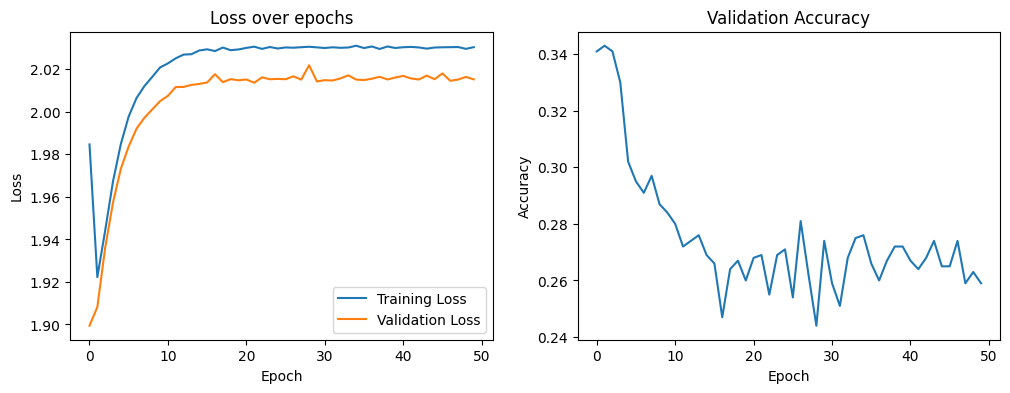

Validation accuracy: 0.2590
result: [(0.01, 128, 0.01, 32, 0.389), (0.01, 128, 0.01, 64, 0.447), (0.01, 128, 0.1, 32, 0.27), (0.01, 128, 0.1, 64, 0.27), (0.01, 256, 0.01, 32, 0.468), (0.01, 256, 0.01, 64, 0.485), (0.01, 256, 0.1, 32, 0.245), (0.01, 256, 0.1, 64, 0.25), (0.01, 512, 0.01, 32, 0.439), (0.01, 512, 0.01, 64, 0.49), (0.01, 512, 0.1, 32, 0.26), (0.01, 512, 0.1, 64, 0.276), (0.005, 128, 0.01, 32, 0.4), (0.005, 128, 0.01, 64, 0.479), (0.005, 128, 0.1, 32, 0.257), (0.005, 128, 0.1, 64, 0.275), (0.005, 256, 0.01, 32, 0.47), (0.005, 256, 0.01, 64, 0.473), (0.005, 256, 0.1, 32, 0.258), (0.005, 256, 0.1, 64, 0.275), (0.005, 512, 0.01, 32, 0.49), (0.005, 512, 0.01, 64, 0.497), (0.005, 512, 0.1, 32, 0.257), (0.005, 512, 0.1, 64, 0.259)]
Best params: {'lr': 0.005, 'hidden_size': 512, 'reg_lambda': 0.01, 'batch_size': 64}
Best validation accuracy: 0.497


In [14]:
best_params, best_accuracy,result=grid_search(X_train,y_train,X_val,y_val, input_size=3072, output_size=10)
print("result:",result)
print("Best params:", best_params)
print("Best validation accuracy:", best_accuracy)

Epoch 1, Train Loss: 1.9299
Epoch 1, Validation Accuracy: 0.3579
Epoch 2, Train Loss: 1.7671
Epoch 2, Validation Accuracy: 0.3913
Epoch 3, Train Loss: 1.6993
Epoch 3, Validation Accuracy: 0.3881
Epoch 4, Train Loss: 1.6505
Epoch 4, Validation Accuracy: 0.3998
Epoch 5, Train Loss: 1.6089
Epoch 5, Validation Accuracy: 0.4286
Epoch 6, Train Loss: 1.5755
Epoch 6, Validation Accuracy: 0.4433
Epoch 7, Train Loss: 1.5483
Epoch 7, Validation Accuracy: 0.4549
Epoch 8, Train Loss: 1.5220
Epoch 8, Validation Accuracy: 0.4416
Epoch 9, Train Loss: 1.4991
Epoch 9, Validation Accuracy: 0.4627
Epoch 10, Train Loss: 1.4803
Epoch 10, Validation Accuracy: 0.4525
Epoch 11, Train Loss: 1.4625
Epoch 11, Validation Accuracy: 0.4747
Epoch 12, Train Loss: 1.4429
Epoch 12, Validation Accuracy: 0.4773
Epoch 13, Train Loss: 1.4281
Epoch 13, Validation Accuracy: 0.4631
Epoch 14, Train Loss: 1.4117
Epoch 14, Validation Accuracy: 0.4779
Epoch 15, Train Loss: 1.3963
Epoch 15, Validation Accuracy: 0.4867
Epoch 16, Tra

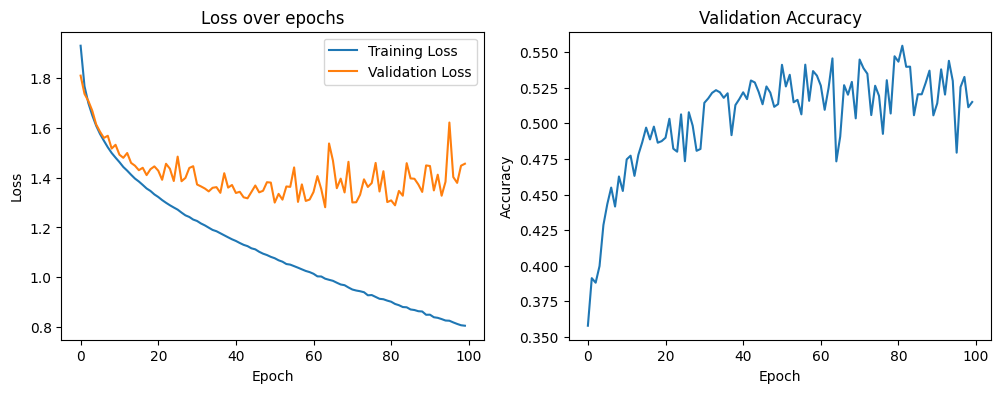

In [35]:
model=NeuralNetwork(input_size=3072,hidden_size=512,output_size=10)
train(X_train,y_train,X_test,y_test_copy,model,epochs=100,batch_size=64,lr=0.005,reg_lambda=0.001)

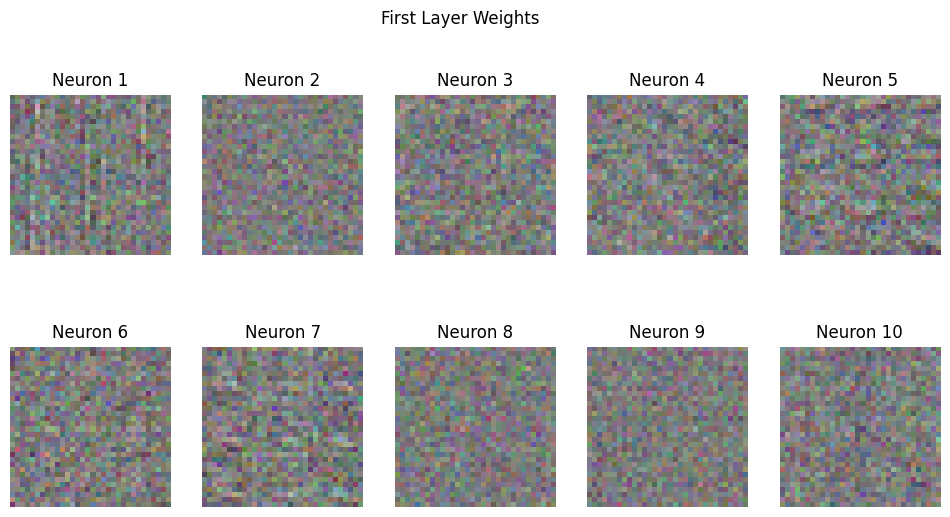

ValueError: cannot reshape array of size 512 into shape (32,32,3)

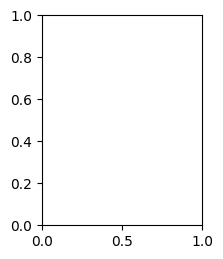

In [38]:
# visualize the weights
def visualize_weights(model):
    W1 = model.params['W1']
    W2 = model.params['W2']
    W3 = model.params['W3']
    # take the weights to [0,1] range
    W1 = (W1 - np.min(W1)) / (np.max(W1) - np.min(W1))
    W2 = (W2 - np.min(W2)) / (np.max(W2) - np.min(W2))
    W3 = (W3 - np.min(W3)) / (np.max(W3) - np.min(W3))
    # Visualize the first layer weights
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(W1[:, i].reshape(32, 32, 3).transpose(1, 0, 2))
        plt.axis('off')
        plt.title(f'Neuron {i + 1}')
    plt.suptitle('First Layer Weights')
    plt.show()

visualize_weights(model)

In [83]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

predictions = model.forward(test_images)

predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(test_labels, predicted_labels)

precision = precision_score(test_labels, predicted_labels, average='macro')

f1 = f1_score(test_labels, predicted_labels, average='macro')

conf_matrix = confusion_matrix(test_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print(conf_matrix)

Accuracy: 0.866
Precision: 0.8667518168151739
F1 Score: 0.8660044125910785
[[805   3  13  37   4   0 125   0  13   0]
 [  4 963   2  23   5   0   1   0   2   0]
 [ 11   1 754  10 141   1  77   0   5   0]
 [ 24  12   9 871  47   1  32   0   4   0]
 [  0   0  89  25 821   0  61   0   4   0]
 [  0   0   0   1   0 942   0  30   2  25]
 [121   3  77  26  83   0 672   0  18   0]
 [  0   0   0   0   0  26   0 912   0  62]
 [  1   1   6   7   7   2  12   6 958   0]
 [  0   0   0   0   0   6   0  31   1 962]]


In [84]:
import pickle
with open('model_params.pkl', 'wb') as f:
    pickle.dump(model.params, f)

# 加载模型参数
with open('model_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)